In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def split_X_y(data):
    y = data.pop("rating_label")
    X = data
    return X, y

def transform_ratings(y, reduce):
    return y - 3 if reduce else y + 3

train = pd.read_csv('/content/drive/My Drive/ML-data/train_final_normalised.csv')
test = pd.read_csv('/content/drive/My Drive/ML-data/test_final_normalised.csv')
predict = pd.read_csv('/content/drive/My Drive/ML-data/predict_final_normalised.csv')

train_X, train_y = split_X_y(train)
test_X, test_y = split_X_y(test)
predict_X = predict

train_y = transform_ratings(train_y, reduce=True)
test_y = transform_ratings(test_y, reduce=True)

from sklearn.model_selection import train_test_split
train_X, validation_X, train_y, validation_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42, shuffle=True)

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)

## Initial Model

In [ ]:
initial_model = keras.Sequential([
    keras.layers.Dense(75, activation='relu', input_shape=(150,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='sigmoid')
])

initial_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history = initial_model.fit(train_X, train_y, epochs=50, class_weight=dict(enumerate(class_weights)), validation_data=(validation_X, validation_y))

In [ ]:
def plot_metrics_history(history, metrics):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_' + metrics])
    plt.ylabel(metrics)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

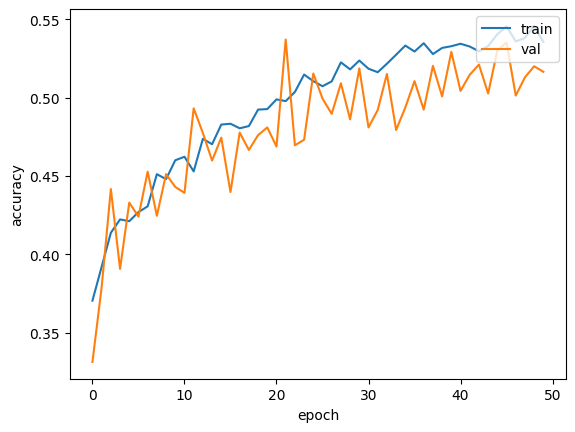

In [ ]:
# plot accuracy graph
plot_metrics_history(history, 'accuracy')

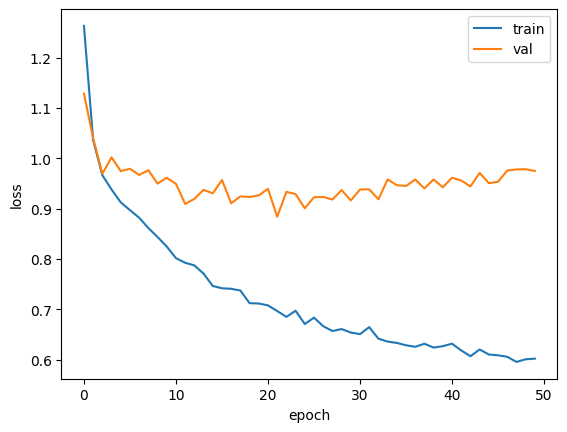

In [ ]:
# plt loss graph
plot_metrics_history(history, 'loss')

In [ ]:
predictions = initial_model.predict(test_X)
test_loss, test_acc = initial_model.evaluate(test_X, test_y, verbose=0)
print('test accuracy:', test_acc)

145/145 [==============================] - 0s 1ms/step
test accuracy: 0.5228701233863831


145/145 [==============================] - 0s 1ms/step


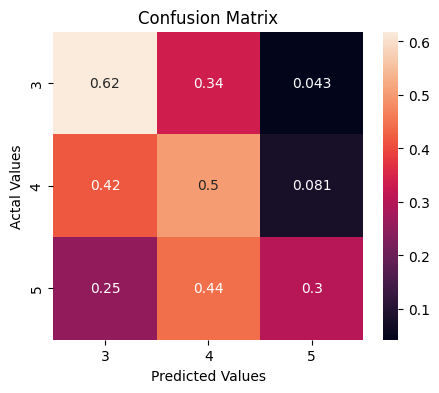

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = initial_model.predict(test_X)
predictions = [np.argmax(pred) for pred in predictions]

cm = confusion_matrix(test_y, predictions)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn, index = ['3','4','5'], columns = ['3','4','5'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
f1_score(test_y, predictions, average='macro')

0.41922683551293427

# Hyperparameter Tuning

In [ ]:
# load the TensorBoard notebook extension
%load_ext tensorboard
# clear any logs from previous runs
!rm -rf ./logs/ 

# import TensorBoard HParams plugin
from tensorboard.plugins.hparams import api as hp

In [ ]:
HP_HIDDEN_LAYERS = hp.HParam('hidden_layers', hp.Discrete([1, 2]))
HP_HL1_NEURONS = hp.HParam('HL1_neurons', hp.Discrete([4, 8, 16, 32, 64, 128, 256, 512]))
HP_HL2_NEURONS = hp.HParam('HL2_neurons', hp.Discrete([4, 8, 16, 32, 64, 128, 256, 512]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop', 'sgd']))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.001, 0.005, 0.01]))
HP_MOMENTUM = hp.HParam('momentum', hp.Discrete([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
HP_DROPOUT_RATE = hp.HParam('dropout_rate', hp.Discrete([0.4, 0.5, 0.6, 0.7, 0.8]))
HP_WEIGHT_INIT = hp.HParam('weight_init', hp.Discrete(['he_normal', 'he_uniform','glorot_normal', 'glorot_uniform']))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([16, 32, 64, 128, 256, 512, 1024, 2048]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_HIDDEN_LAYERS, HP_HL1_NEURONS, HP_HL2_NEURONS,
                 HP_OPTIMIZER, HP_LEARNING_RATE, HP_MOMENTUM, HP_DROPOUT_RATE, 
                 HP_WEIGHT_INIT, HP_BATCH_SIZE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [ ]:
from sklearn.model_selection import KFold

def build_model(hparams):
    hidden_neurons = [hparams[HP_HL1_NEURONS], hparams[HP_HL2_NEURONS]]

    model = keras.Sequential()
    model.add(keras.layers.Dense(hidden_neurons[0], activation='relu', input_shape=(150,), kernel_initializer=hparams[HP_WEIGHT_INIT]))
    model.add(keras.layers.Dropout(hparams[HP_DROPOUT_RATE]))
    
    for L in range(1, hparams[HP_HIDDEN_LAYERS]):
        model.add(keras.layers.Dense(hidden_neurons[L], activation='relu', kernel_initializer=hparams[HP_WEIGHT_INIT]))
        model.add(keras.layers.Dropout(hparams[HP_DROPOUT_RATE]))
    
    model.add(keras.layers.Dense(3, activation='sigmoid', kernel_initializer=hparams[HP_WEIGHT_INIT]))

    optimizer = hparams[HP_OPTIMIZER]
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE])
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hparams[HP_LEARNING_RATE], momentum=hparams[HP_MOMENTUM])
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=hparams[HP_LEARNING_RATE], momentum=hparams[HP_MOMENTUM])

    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    model.fit(train_X, train_y, epochs=200, class_weight=dict(enumerate(class_weights)), batch_size=hparams[HP_BATCH_SIZE], verbose=2, callbacks=[early_stop], validation_data=(validation_X, validation_y))
    _, accuracy = model.evaluate(validation_X, validation_y)
    return accuracy

In [ ]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        accuracy = build_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
num_iterations = 10

for iteration in range(num_iterations):
    hparams = {
        HP_HIDDEN_LAYERS : HP_HIDDEN_LAYERS.domain.sample_uniform(),
        HP_HL1_NEURONS : HP_HL1_NEURONS.domain.sample_uniform(),
        HP_HL2_NEURONS : HP_HL2_NEURONS.domain.sample_uniform(),
        HP_OPTIMIZER : HP_OPTIMIZER.domain.sample_uniform(),
        HP_LEARNING_RATE : HP_LEARNING_RATE.domain.sample_uniform(),
        HP_MOMENTUM : HP_MOMENTUM.domain.sample_uniform(),
        HP_DROPOUT_RATE : HP_DROPOUT_RATE.domain.sample_uniform(),
        HP_WEIGHT_INIT : HP_WEIGHT_INIT.domain.sample_uniform(),
        HP_BATCH_SIZE : HP_BATCH_SIZE.domain.sample_uniform()}

    run_name = "run-%d" % (iteration+1)
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)

In [ ]:
%tensorboard --logdir logs/hparam_tuning

## Final Model

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(32, activation='relu', input_shape=(150,), kernel_initializer='glorot_uniform'))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Dense(3, activation='sigmoid', kernel_initializer='glorot_uniform'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
model_history = model.fit(train_X, train_y, epochs=100, class_weight=dict(enumerate(class_weights)), batch_size=2048, callbacks=[early_stop], validation_data=(validation_X, validation_y))

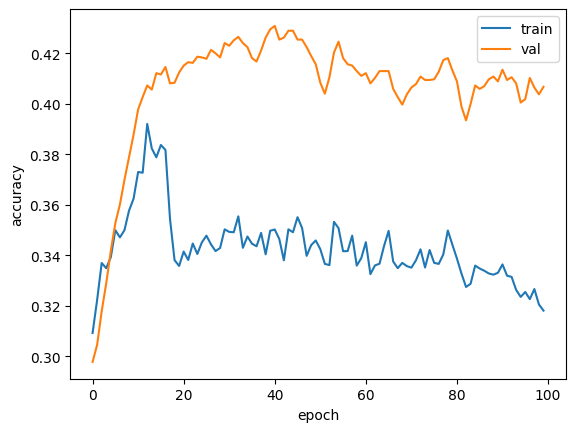

In [ ]:
plot_metrics_history(model_history, 'accuracy')

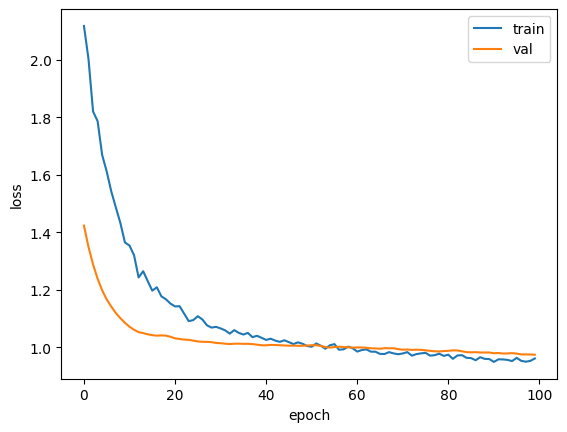

In [ ]:
plot_metrics_history(model_history, 'loss')

In [ ]:
predictions = model.predict(test_X)
test_loss, test_acc = model.evaluate(test_X, test_y, verbose=0)
print('test accuracy:', test_acc)

145/145 [==============================] - 0s 1ms/step
test accuracy: 0.40797746181488037


145/145 [==============================] - 0s 1ms/step


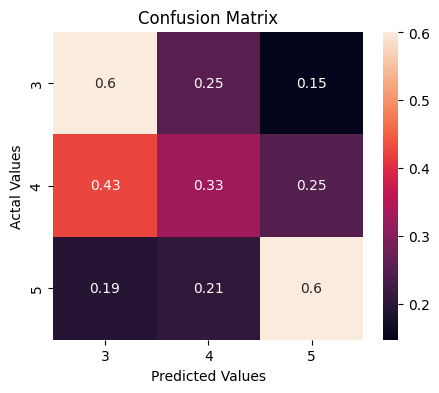

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_X)
predictions = [np.argmax(pred) for pred in predictions]

cm = confusion_matrix(test_y, predictions)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn, index = ['3','4','5'], columns = ['3','4','5'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
f1_score(test_y, predictions, average='macro')

0.3560191155994459